Pictures Classification with Xception

In [1]:
# Import the librairies

import tensorflow
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow import losses
import os
import pathlib
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt

In [2]:
# Create a path to the dataset

data_dir = pathlib.Path('/Users/bil/Documents/Formation_Datascientist/Projet_Formation/Datasets/COVID-19_Radiography_Dataset/Images')

In [3]:
# Total of pictures

image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

21165


In [4]:
# Number of pictures per class

covid = list(data_dir.glob('covid/images/*'))
print("Total Covid :",len(covid))
normal = list(data_dir.glob('normal/images/*'))
print("Total Normal :",len(normal))
lung_opacity = list(data_dir.glob('opacity/images/*'))
print("Total Lung Opacity :",len(lung_opacity))
viral_pneumonia = list(data_dir.glob('viral/images/*'))
print("Total Viral Pneumonia :",len(viral_pneumonia))

Total Covid : 3616
Total Normal : 10192
Total Lung Opacity : 6012
Total Viral Pneumonia : 1345


In [5]:
# Load the pictures from a directory and create a subfolder for the training

train_ds = image_dataset_from_directory(data_dir,
                                                       validation_split = 0.3,
                                                       subset = 'training',
                                                       seed = 123,
                                                       image_size =(150,150),
                                                       batch_size = 32)

class_names = train_ds.class_names
print("Class names are :", class_names)

Found 21165 files belonging to 4 classes.
Using 14816 files for training.
Class names are : ['covid', 'normal', 'opacity', 'viral']


2025-09-16 16:10:09.804215: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-16 16:10:09.804253: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-16 16:10:09.804263: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-16 16:10:09.804278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-16 16:10:09.804289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Create a subfolder for the validation

val_ds = image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = 123,
                                                       image_size = (150,150),
                                                       batch_size = 32)

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [7]:
# Create a subfolder for the test

test_ds = image_dataset_from_directory(data_dir,
                                                       validation_split = 0.1,
                                                       subset = 'validation',
                                                       seed = 123,
                                                       image_size = (150,150),
                                                       batch_size = 32)

Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


In [8]:
import numpy as np

for image_batch, labels_batch in train_ds :
  print(image_batch.shape)
  print(labels_batch.shape)
  break

first_image = image_batch[0]

# Pixels min and max

print(np.min(first_image), np.max(first_image))

(32, 150, 150, 3)
(32,)
0.0 218.31427


2025-09-16 16:10:25.335880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


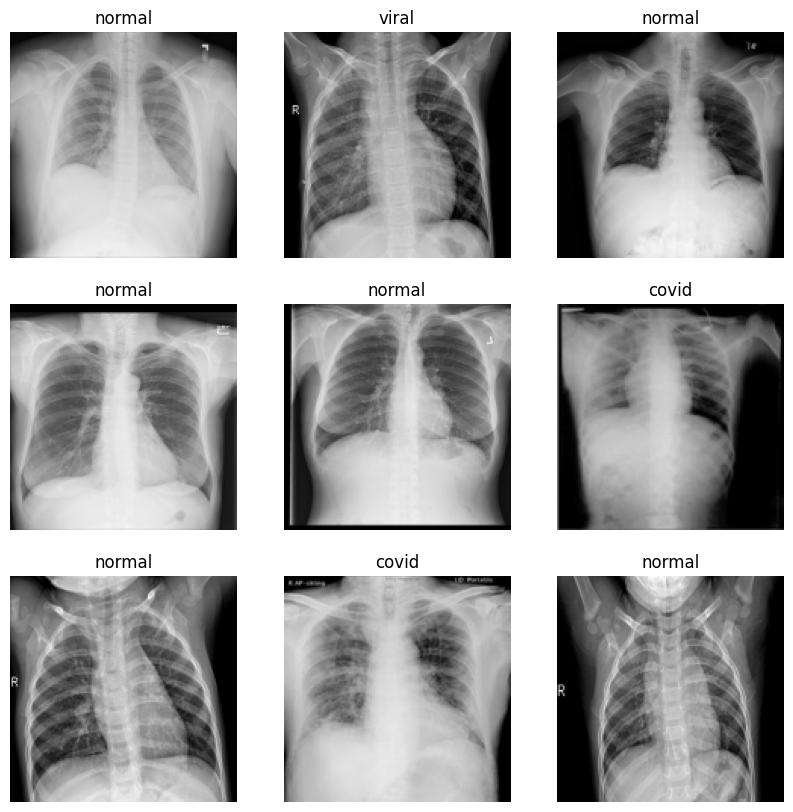

In [ ]:
# Visualisation of the firsts 9 pictures of the train set 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch overlaps data preprocessing and model execution while training.

In [10]:
from tensorflow import data
AUTOTUNE = data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Transfert learning with Xception

In [11]:
# Build the model

img_shape = (150,150,3)
base_model = tensorflow.keras.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=img_shape,
                                            pooling='max')


x_model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early = EarlyStopping(
                                patience=5, 
                                min_delta = 0.01, 
                                verbose=1, 
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, 
                                    min_delta= 0.01,
                                    factor=0.5,  
                                    verbose=1)


# Compilation

x_model.compile(
  optimizer='adam',
  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# base_model.trainable = False

x_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [12]:
# Train the model with the callbacks on GPU

import time
start = time.time()

with tensorflow.device("GPU:0"):
    x_history = x_model.fit(train_ds, epochs=10,validation_data=val_ds,callbacks=[early,reduce_learning_rate])

end = time.time()
result = end-start
print("On GPU: {:0.2f}s".format(result))

x_model.save("Xception_model.keras")

Epoch 1/10


2025-09-16 16:11:47.605962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


463/463 ━━━━━━━━━━━━━━━━━━━━ 1093s 2s/step - accuracy: 0.8373 - loss: 0.5259 - val_accuracy: 0.8727 - val_loss: 0.5141 - learning_rate: 0.0010
Epoch 2/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - accuracy: 0.9036 - loss: 0.3309 - val_accuracy: 0.8861 - val_loss: 0.4642 - learning_rate: 0.0010
Epoch 3/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - accuracy: 0.9240 - loss: 0.2514 - val_accuracy: 0.7616 - val_loss: 1.5668 - learning_rate: 0.0010
Epoch 4/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.9249 - loss: 0.2418 - val_accuracy: 0.8396 - val_loss: 1.0600 - learning_rate: 0.0010
Epoch 5/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 709s 2s/step - accuracy: 0.9278 - loss: 0.2259 - val_accuracy: 0.8984 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 6/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - accuracy: 0.9316 - loss: 0.2151 - val_accuracy: 0.8779 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 7/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.9438 - loss: 0.1755 - val

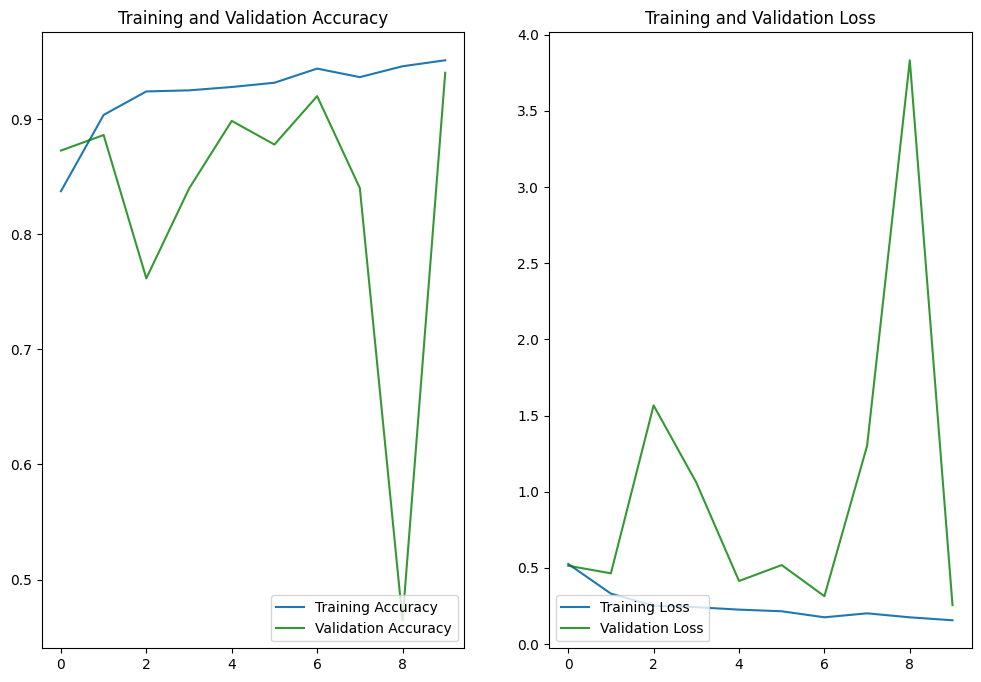

In [13]:
import matplotlib.pyplot as plt

acc = x_history.history['accuracy']
val_acc = x_history.history['val_accuracy']

loss = x_history.history['loss']
val_loss = x_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, c='green', alpha = 0.8, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, c='green', alpha = 0.8, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.savefig("Keras train-validation scores.png")
plt.show()

In [14]:
# Classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

predictions = np.array([])
labels =  np.array([])
for data, label in test_ds:
    predictions = np.concatenate([predictions, np.argmax(x_model(data), axis=-1)])
    labels = np.concatenate([labels, label.numpy()])

c_r = classification_report(labels, predictions, target_names=class_names)
print("Classification Report:\n----------------------\n", c_r)

Classification Report:
----------------------
               precision    recall  f1-score   support

       covid       0.92      0.98      0.95       373
      normal       0.95      0.93      0.94       989
     opacity       0.94      0.88      0.91       611
       viral       0.80      0.98      0.88       143

    accuracy                           0.93      2116
   macro avg       0.90      0.94      0.92      2116
weighted avg       0.93      0.93      0.93      2116



2025-09-16 18:20:35.936428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
# Confusion matrix
cm = confusion_matrix(labels, predictions,normalize=None)        


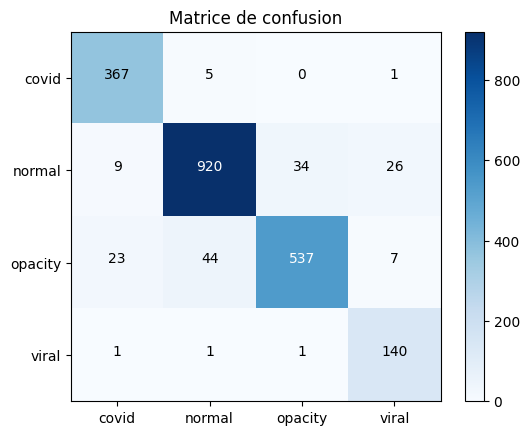

In [16]:
# Afficher une matrice de confusion sous forme de tableau coloré
import itertools
classes = range(0,4)

plt.figure()

plt.imshow(cm, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > ( cm.max() / 2) else "black")

plt.show()

Le taux d'exactitude de prédiction Covid est de 100.0 %.


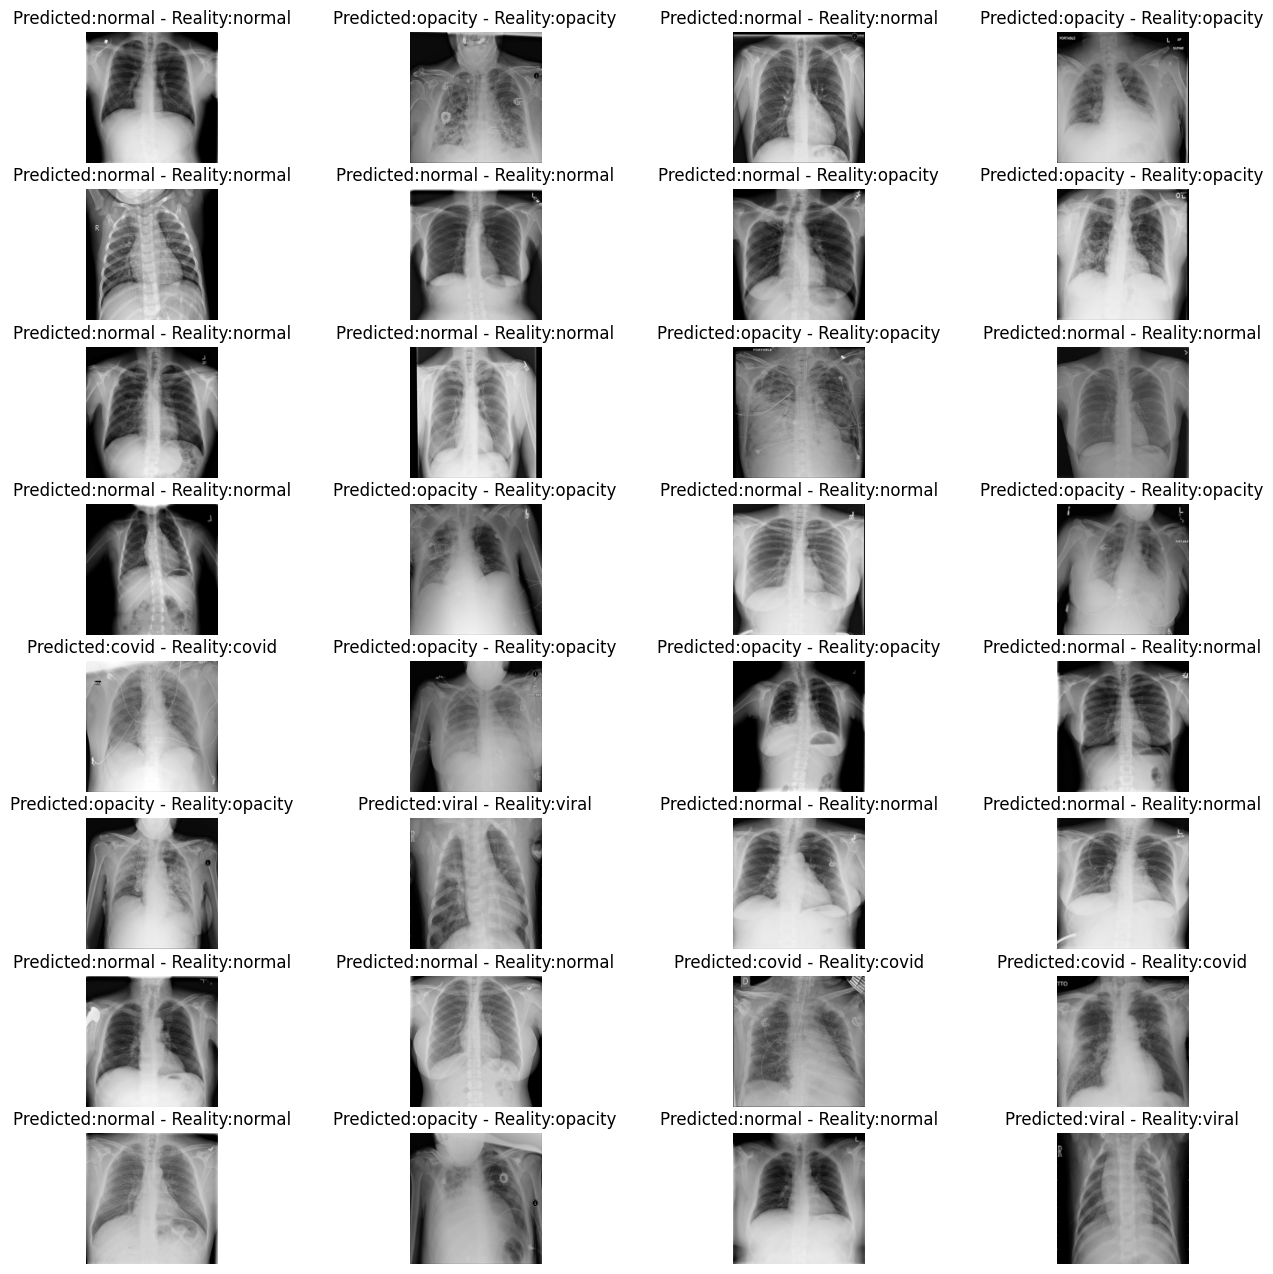

In [ ]:
# Use the model on a random batch of pictures from the test set to predict 

loaded_model = tensorflow.keras.models.load_model("Xception_model.keras")
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = loaded_model.predict_on_batch(image_batch)

# Apply argmax on predictions to select the highest probablity between covid and no covid

predictions = np.argmax(predictions,axis=1)

plt.figure(figsize=(16,16))
exactitude = 0
covid_cases = 0
for i in range(32) :
    if class_names[predictions[i]] == 'covid' :
        covid_cases += 1
        if class_names[predictions[i]] == class_names[label_batch[i]] :
            exactitude += 1 
    
    plt.subplot(8,4,i+1)
    plt.imshow(image_batch[i].astype("uint8"));
    plt.title("Predicted:{} - Reality:{}".format(class_names[predictions[i]],
                                class_names[label_batch[i]]),
                                )
    plt.axis("off");

performance = exactitude/covid_cases
print(f"Le taux d'exactitude de prédiction Covid est de {np.round(100*performance,1)} %.")